# Logistics Analysis

The purpose of this project is to analyze delivery performance and identify the key factors contributing to delays in the logistics operations of a delivery company. 

By examining various aspects such as trip time deviations, route-specific issues, and operational inefficiencies, the goal is to uncover areas for optimization in delivery scheduling, route planning, and resource allocation. 

#### Dataset

The Delhivery Logistics Dataset includes:

**Trip Details**:
- Source and destination locations.
- Distance of the delivery trip.
- Estimated and actual delivery times.
- Cutoff times and adherence to deadlines.
- Route type (e.g., Full Truck Load (FTL), Carting).

**Route Information**:
- Specific route pairs that are traveled during deliveries.
- Associated delays or deviations from expected times.
- Traffic conditions and regional factors affecting deliveries.

**Operational Metrics**:
- Success and failure rates of deliveries.
- Time deviations, both average and median, for different trips.
- Variability in delivery times across different routes and regions.

**Delivery Success/Failure**:
- Whether deliveries were on time or delayed.

**Geographic and Temporal Data**:
- Delivery success rates across different regions (e.g., Uttar Pradesh, Maharashtra).
- Time-of-day data, which might indicate peak and off-peak hours for deliveries.

**Performance Metrics**:
- Metrics such as average delay, standard deviation of delays, and percentage of delayed trips.
- Routes or regions that consistently perform poorly in terms of on-time delivery.

## 1. Data Loading and Cleaning

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from scipy import stats
from scipy.stats import chi2_contingency

# Load dataset
df = pd.read_csv("delhivery.csv")
print("Dataset loaded successfully!")

Dataset loaded successfully!


In [2]:
# Data Cleaning
print("\nHandling missing values...")
categorical_columns = ['source_name', 'destination_name']
df[categorical_columns] = df[categorical_columns].fillna('Unknown')

numerical_columns = ['actual_distance_to_destination', 'actual_time', 'osrm_time']
df[numerical_columns] = df[numerical_columns].apply(lambda x: x.fillna(x.median()))

df = df[df['actual_time'] > 0]
df = df[df['actual_distance_to_destination'] > 0]
df = df[df['osrm_time'] > 0]


Handling missing values...


In [3]:
# Convert timestamps to datetime
time_columns = ['trip_creation_time', 'od_start_time', 'od_end_time', 'cutoff_timestamp']
for col in time_columns:
    df[col] = pd.to_datetime(df[col], errors='coerce')

df.dropna(subset=['od_start_time'], inplace=True)
df['hour_of_day'] = df['od_start_time'].dt.hour
df['day_of_week'] = df['od_start_time'].dt.dayofweek

print("Data Cleaning Completed!\n")

Data Cleaning Completed!



In [4]:
df.head()

,data,trip_creation_time,route_schedule_uuid,route_type,trip_uuid,source_center,source_name,destination_center,destination_name,od_start_time,...,actual_time,osrm_time,osrm_distance,factor,segment_actual_time,segment_osrm_time,segment_osrm_distance,segment_factor,hour_of_day,day_of_week
0,training,2018-09-20 02:35:36.476840,thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...,Carting,trip-153741093647649320,IND388121AAA,Anand_VUNagar_DC (Gujarat),IND388620AAB,Khambhat_MotvdDPP_D (Gujarat),2018-09-20 03:21:32.418600,...,14.0,11.0,11.9653,1.272727,14.0,11.0,11.9653,1.272727,3,3
1,training,2018-09-20 02:35:36.476840,thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...,Carting,trip-153741093647649320,IND388121AAA,Anand_VUNagar_DC (Gujarat),IND388620AAB,Khambhat_MotvdDPP_D (Gujarat),2018-09-20 03:21:32.418600,...,24.0,20.0,21.7243,1.200000,10.0,9.0,9.7590,1.111111,3,3
2,training,2018-09-20 02:35:36.476840,thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...,Carting,trip-153741093647649320,IND388121AAA,Anand_VUNagar_DC (Gujarat),IND388620AAB,Khambhat_MotvdDPP_D (Gujarat),2018-09-20 03:21:32.418600,...,40.0,28.0,32.5395,1.428571,16.0,7.0,10.8152,2.285714,3,3
3,training,2018-09-20 02:35:36.476840,thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...,Carting,trip-153741093647649320,IND388121AAA,Anand_VUNagar_DC (Gujarat),IND388620AAB,Khambhat_MotvdDPP_D (Gujarat),2018-09-20 03:21:32.418600,...,62.0,40.0,45.5620,1.550000,21.0,12.0,13.0224,1.750000,3,3
4,training,2018-09-20 02:35:36.476840,thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...,Carting,trip-153741093647649320,IND388121AAA,Anand_VUNagar_DC (Gujarat),IND388620AAB,Khambhat_MotvdDPP_D (Gujarat),2018-09-20 03:21:32.418600,...,68.0,44.0,54.2181,1.545455,6.0,5.0,3.9153,1.200000,3,3


## 2. Exploratory Data Analysis (EDA)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144867 entries, 0 to 144866
Data columns (total 26 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   data                            144867 non-null  object        
 1   trip_creation_time              144867 non-null  datetime64[ns]
 2   route_schedule_uuid             144867 non-null  object        
 3   route_type                      144867 non-null  object        
 4   trip_uuid                       144867 non-null  object        
 5   source_center                   144867 non-null  object        
 6   source_name                     144867 non-null  object        
 7   destination_center              144867 non-null  object        
 8   destination_name                144867 non-null  object        
 9   od_start_time                   144867 non-null  datetime64[ns]
 10  od_end_time                     144867 non-null  datetim

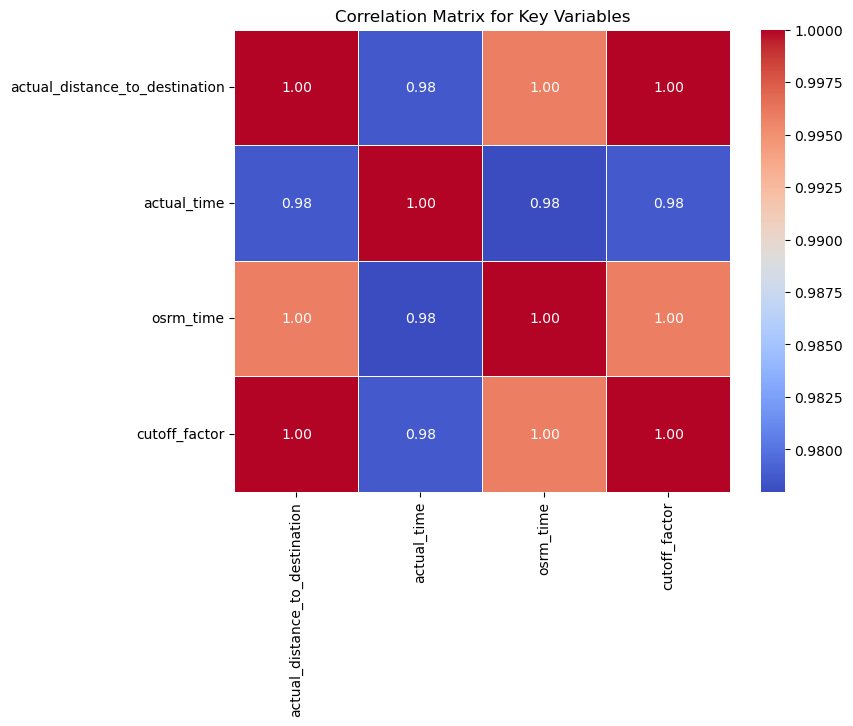

In [7]:
# Correlation Analysis
correlation_matrix = df[['actual_distance_to_destination', 'actual_time', 'osrm_time', 'cutoff_factor']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix for Key Variables')
plt.show()

Pairplot is used to visualize relationships between actual_distance_to_destination, actual_time, osrm_time, and cutoff_factor.

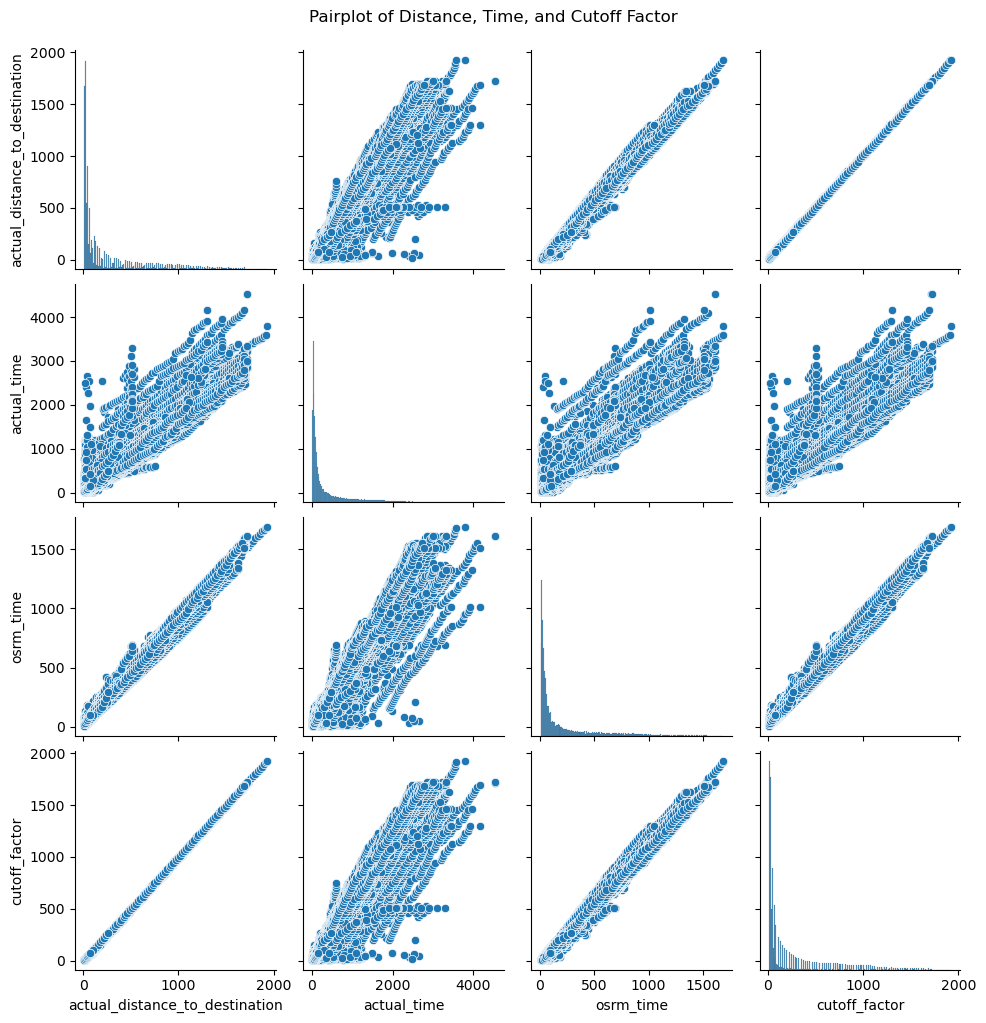

In [9]:
# Pairplot for Visualizing Relationships
sns.pairplot(df[['actual_distance_to_destination', 'actual_time', 'osrm_time', 'cutoff_factor']])
plt.suptitle('Pairplot of Distance, Time, and Cutoff Factor', y=1.02)
plt.show()

Boxplot of actual_time against binned ranges of actual_distance_to_destination.

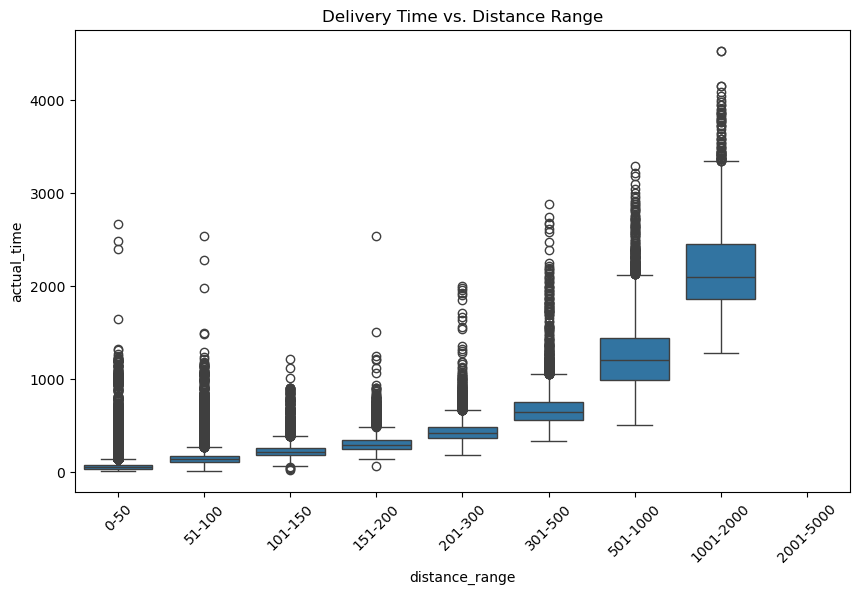

In [10]:
# Boxplot for Delivery Time vs. Distance
bins = [0, 50, 100, 150, 200, 300, 500, 1000, 2000, 5000]
labels = ['0-50', '51-100', '101-150', '151-200', '201-300', '301-500', '501-1000', '1001-2000', '2001-5000']
df['distance_range'] = pd.cut(df['actual_distance_to_destination'], bins=bins, labels=labels)

plt.figure(figsize=(10, 6))
sns.boxplot(x='distance_range', y='actual_time', data=df)
plt.title('Delivery Time vs. Distance Range')
plt.xticks(rotation=45)
plt.show()

Average delivery time by hour of day is visualized with a line plot.

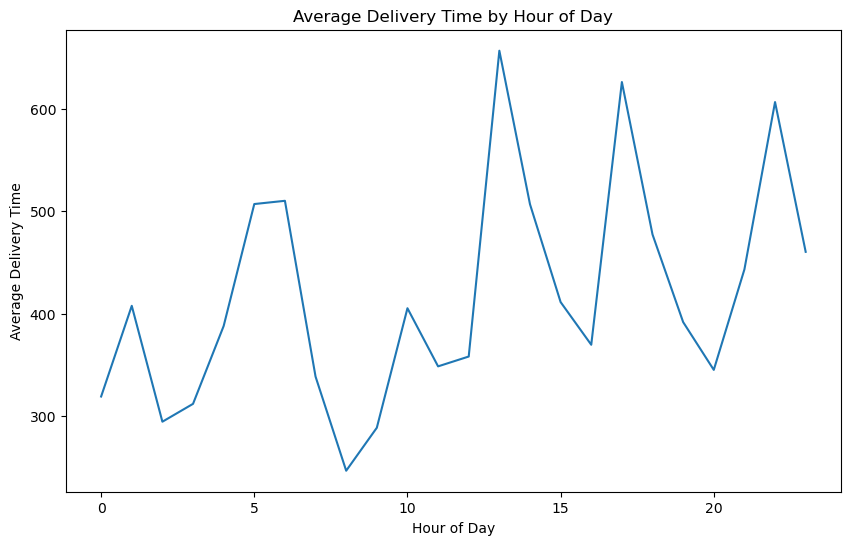

In [11]:
# Time-of-Day Analysis
avg_delivery_time_by_hour = df.groupby('hour_of_day')['actual_time'].mean()
plt.figure(figsize=(10, 6))
sns.lineplot(x=avg_delivery_time_by_hour.index, y=avg_delivery_time_by_hour.values)
plt.title('Average Delivery Time by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Average Delivery Time')
plt.show()

## 3. Outlier Detection

In [12]:
# Outlier Detection
z_scores = stats.zscore(df['actual_time'])
outliers = df[(z_scores > 3) | (z_scores < -3)]
print("Outliers detected in delivery time:")
print(outliers[['actual_time', 'actual_distance_to_destination', 'cutoff_factor']].head())

Outliers detected in delivery time:
     actual_time  actual_distance_to_destination  cutoff_factor
709       2233.0                     1430.552868           1430
710       2323.0                     1454.404582           1452
711       2410.0                     1474.182597           1474
712       2461.0                     1496.298945           1496
713       2500.0                     1519.015521           1518


### Key Findings

Five records show the values for actual_time, actual_distance_to_destination, and cutoff_factor are unusually high compared to the rest of the dataset.

#### **Potential Reasons for Outliers**
- **Long-distance deliveries**: These might be legitimate cases of long-distance orders.
- **Traffic or Delays**: Unusual delays due to traffic jams, road closures, or other disruptions.
- **Data Entry Errors**: There could be issues like double logging or unit conversion errors.
- **Unusual Route Choices**: Possibly due to detours, accidents, or navigation errors.

## 4. Delivery Outcome Analysis

This approach gives you more nuanced insights into your delivery performance by creating categories based on the percentage delay rather than just a fixed threshold.

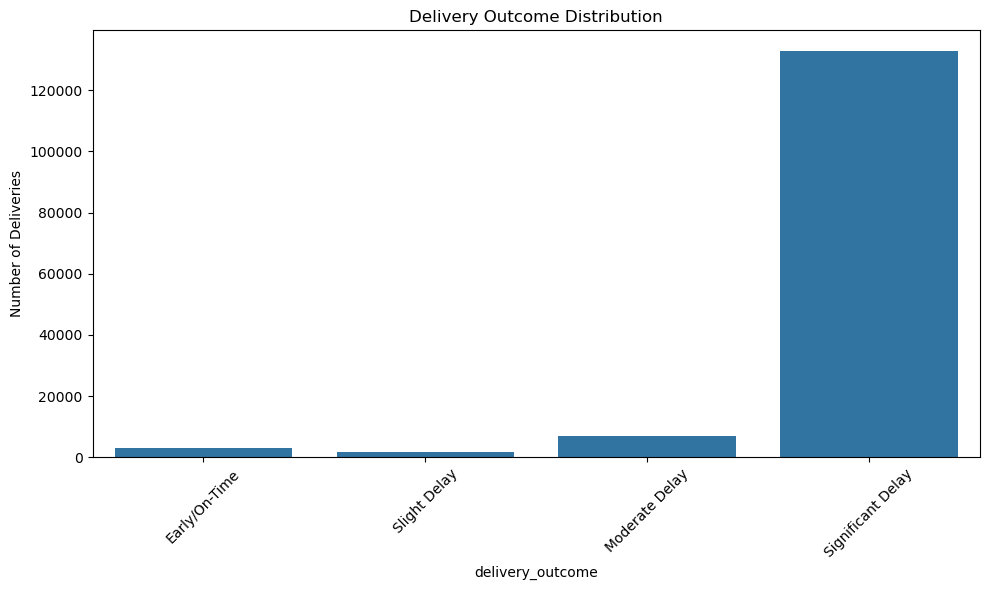

Delivery Outcome Percentages:
Significant Delay: 91.76%
Moderate Delay: 4.83%
Early/On-Time: 2.16%
Slight Delay: 1.26%


In [13]:
# Calculate percentage deviation from expected time
df['time_deviation_pct'] = ((df['actual_time'] - df['osrm_time']) / df['osrm_time']) * 100

# Define different severity levels for delivery outcomes
df['delivery_outcome'] = pd.cut(
    df['time_deviation_pct'],
    bins=[-float('inf'), 0, 10, 30, float('inf')],
    labels=['Early/On-Time', 'Slight Delay', 'Moderate Delay', 'Significant Delay']
)

# Visualize the distribution of delivery outcomes
plt.figure(figsize=(10, 6))
delivery_counts = df['delivery_outcome'].value_counts().sort_index()
sns.barplot(x=delivery_counts.index, y=delivery_counts.values)
plt.title('Delivery Outcome Distribution')
plt.ylabel('Number of Deliveries')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Calculate percentage of each outcome
outcome_percentages = df['delivery_outcome'].value_counts(normalize=True) * 100
print("Delivery Outcome Percentages:")
for outcome, percentage in outcome_percentages.items():
    print(f"{outcome}: {percentage:.2f}%")

### Key Findings

- The extremely high rate of significant delays (over 90%) is alarming and indicates a need for urgent operational review.
- The low percentage of early/on-time deliveries suggests that the current logistics model or time estimation methods are not accurate.

## 5. Performance Analysis by Route Type


Delivery Performance by Route Type:
  route_type  avg_deviation_pct  median_deviation_pct  trip_count  \
0    Carting         140.984211             91.666667       45207   
1        FTL          98.867987             84.467858       99660   

   delay_rate_pct  
0       96.285973  
1       98.552077  


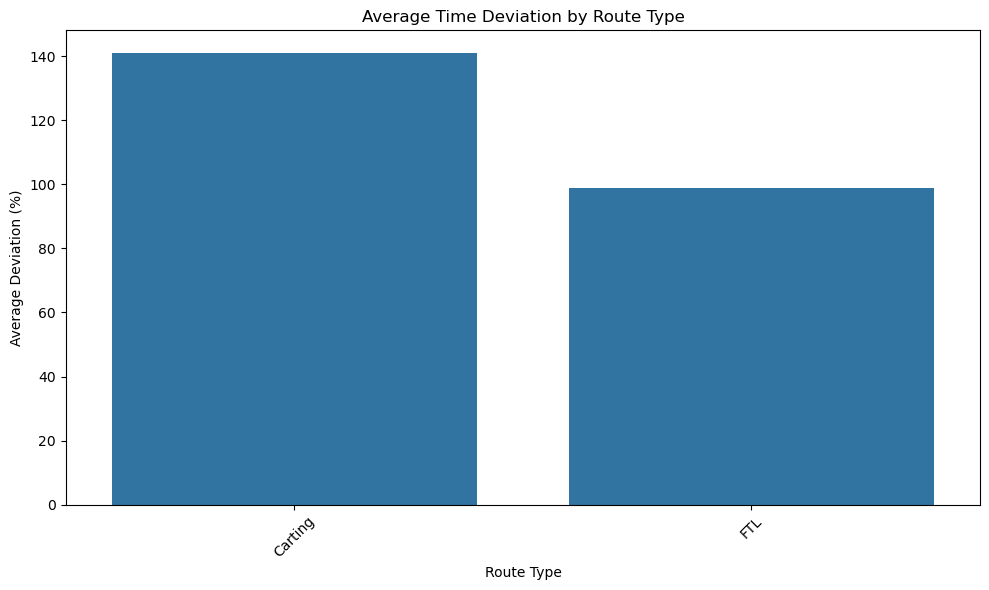

In [14]:
# Analyze delivery performance by route_type
route_performance = df.groupby('route_type').agg({
    'time_deviation_pct': ['mean', 'median', 'count'],
    'delivery_outcome': lambda x: (x != 'Early/On-Time').mean() * 100
}).reset_index()

# Rename columns for clarity
route_performance.columns = ['route_type', 'avg_deviation_pct', 'median_deviation_pct', 
                             'trip_count', 'delay_rate_pct']

print("\nDelivery Performance by Route Type:")
print(route_performance)

# Visualization of performance by route_type
plt.figure(figsize=(10, 6))
sns.barplot(x='route_type', y='avg_deviation_pct', data=route_performance)
plt.title('Average Time Deviation by Route Type')
plt.xlabel('Route Type')
plt.ylabel('Average Deviation (%)')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

### Key Findings

- Both route types have alarmingly high delay rates, but FTL shows slightly worse performance than Carting.
- The high average and median deviations indicate significant mismatches between estimated and actual delivery times, potentially due to poor route planning, traffic issues, or inaccurate time estimates.
- Given the high trip count, FTL should be a priority for operational improvements, as it affects more deliveries.

## 6. Route Pair Analysis

"Which routes have the highest variance between actual time and expected time?"

Since you also have route_schedule_uuid, which seems to contain more detailed route information (as shown in your output), we can do a more comprehensive analysis:


Top 10 Route Pairs with Highest Average Time Deviation:
                                     source  \
2137     Phulpur_Shekhpur_D (Uttar Pradesh)   
1741        Malvan_BllvMarg_D (Maharashtra)   
1410     Kanpur_Central_D_7 (Uttar Pradesh)   
49    Allahabad_Central_D_3 (Uttar Pradesh)   
1530    Kirauli_AchneraRD_D (Uttar Pradesh)   
2423      Shirpur_KrantiNgr_D (Maharashtra)   
1135      Helencha_ColnyDPP_D (West Bengal)   
1723     Majalgaon_SmbjiCwk_D (Maharashtra)   
1409     Kanpur_Central_D_5 (Uttar Pradesh)   
2680       Unnao_VikasRam_D (Uttar Pradesh)   

                                destination  avg_deviation_pct  \
2137  Allahabad_Central_H_1 (Uttar Pradesh)        3385.105300   
1741    Sawantwadi_LaxmiNgr_D (Maharashtra)        2255.610726   
1410     Kanpur_Central_H_6 (Uttar Pradesh)        2118.362391   
49    Allahabad_Central_H_1 (Uttar Pradesh)        1918.961640   
1530                   Agra (Uttar Pradesh)        1743.702845   
2423         Dhule_MIDCAvdn_I

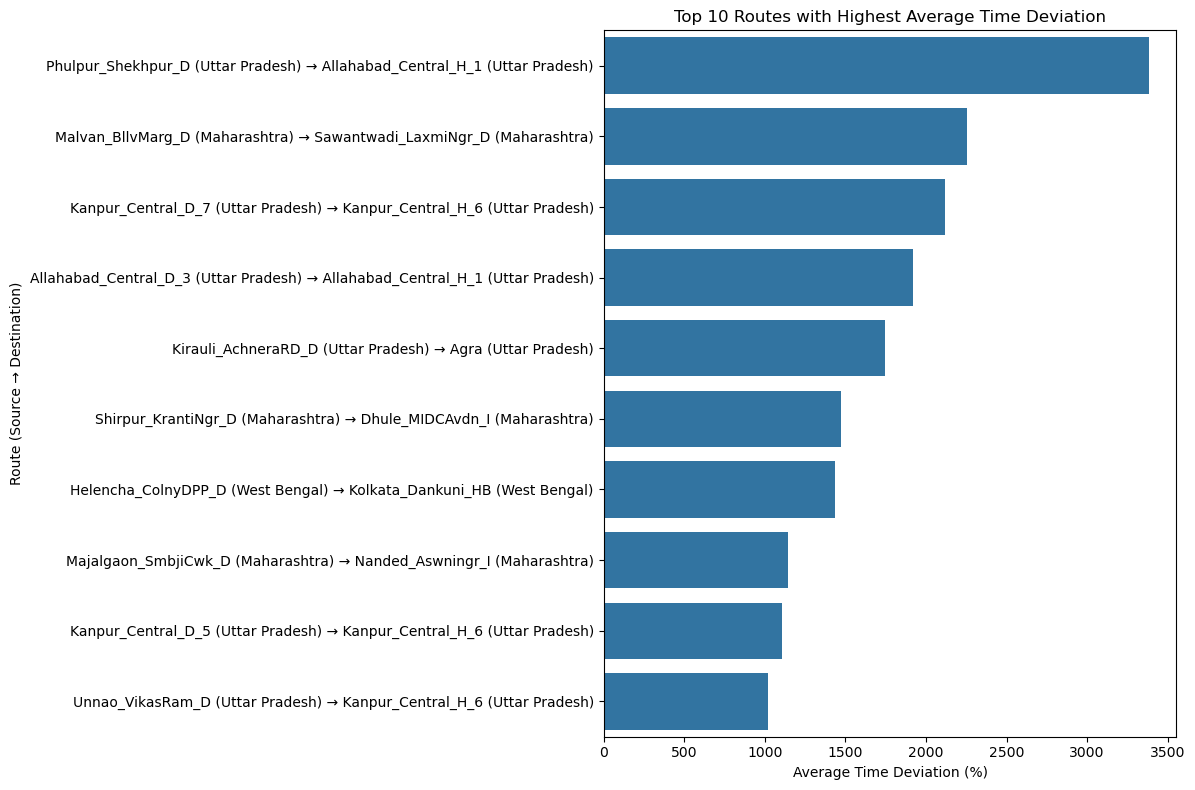

In [15]:
# Group by source and destination to identify problematic route pairs
route_pair_performance = df.groupby(['source_name', 'destination_name']).agg({
    'time_deviation_pct': ['mean', 'median', 'std', 'count'],
    'delivery_outcome': lambda x: (x != 'Early/On-Time').mean() * 100
}).reset_index()

route_pair_performance.columns = ['source', 'destination', 'avg_deviation_pct', 
                                 'median_deviation_pct', 'std_deviation_pct',
                                 'trip_count', 'delay_rate_pct']

# Filter for routes with sufficient data (at least 5 trips)
route_pair_performance = route_pair_performance[route_pair_performance['trip_count'] >= 5]

print("\nTop 10 Route Pairs with Highest Average Time Deviation:")
print(route_pair_performance.sort_values('avg_deviation_pct', ascending=False).head(10))

# For visualization, let's create a plot of the top problem routes
top_problem_routes = route_pair_performance.sort_values('avg_deviation_pct', ascending=False).head(10)
plt.figure(figsize=(12, 8))
sns.barplot(y=top_problem_routes['source'] + ' → ' + top_problem_routes['destination'], 
           x='avg_deviation_pct', data=top_problem_routes)
plt.title('Top 10 Routes with Highest Average Time Deviation')
plt.xlabel('Average Time Deviation (%)')
plt.ylabel('Route (Source → Destination)')
plt.tight_layout()
plt.show()

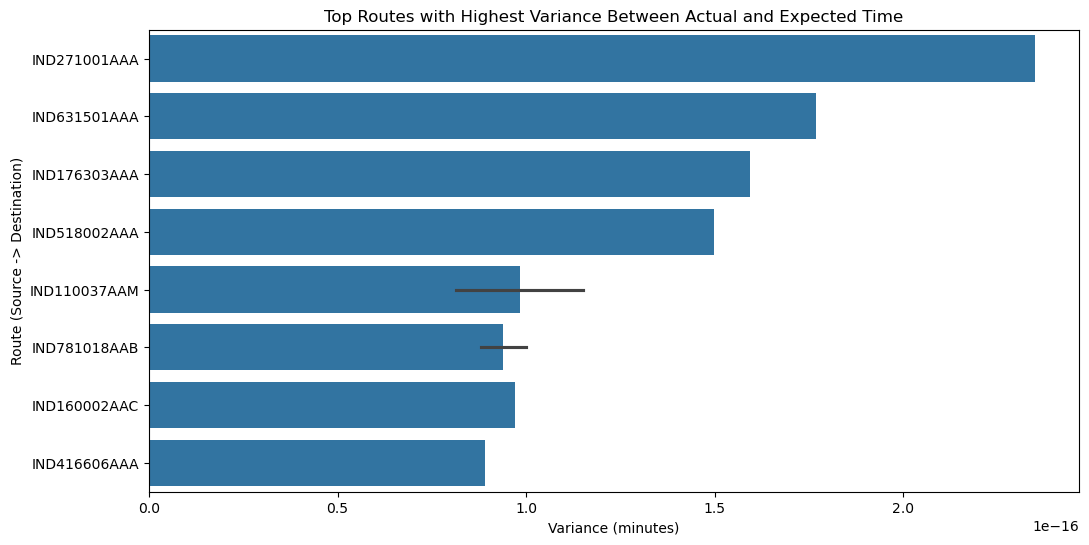

In [16]:
# Route Variance Analysis

# Ensure the 'actual_time' and 'osrm_time' columns are in datetime format
df['actual_time'] = pd.to_datetime(df['actual_time'])
df['osrm_time'] = pd.to_datetime(df['osrm_time'])

# Calculate the time difference in minutes
df['time_difference'] = (df['actual_time'] - df['osrm_time']).dt.total_seconds() / 60

# Group by source and destination centers, then calculate variance
route_variance = df.groupby(['source_center', 'destination_center'])['time_difference'].var().reset_index()

# Sort the results by time_difference variance
route_variance_sorted = route_variance.sort_values(by='time_difference', ascending=False)

# Get the top 10 routes with the highest variance
top_routes = route_variance_sorted.head(10)

# Plot the results
plt.figure(figsize=(12, 6))
sns.barplot(x='time_difference', y='source_center', data=top_routes, orient='h')
plt.title('Top Routes with Highest Variance Between Actual and Expected Time')
plt.xlabel('Variance (minutes)')
plt.ylabel('Route (Source -> Destination)')
plt.show()

### Key Findings

- **Severe Delays on Specific Routes**: All top 10 route pairs show extraordinarily high average deviations, indicating severe and systemic delays.
- **Consistent Delays**: The median deviation is also high across all routes, meaning delays are consistently occurring rather than being isolated incidents.
- **100% Delay Rate**: Every trip on these routes was delayed, pointing to serious issues with planning, route optimization, or other logistical factors.
- **High Variability**: Standard deviations are high for most routes, indicating fluctuating delivery times, possibly due to traffic conditions, poor route estimation, or operational disruptions.
- **Route Concentration**: Many of the worst-performing routes are concentrated in Uttar Pradesh and Maharashtra, suggesting regional operational challenges.

## 7. Distance vs. Time Deviation Analysis

"How does the actual distance to destination correlate with the actual delivery time?"

Finally, let's examine if there's a correlation between distance and time deviation, addressing your question about the impact of distance on delivery time:

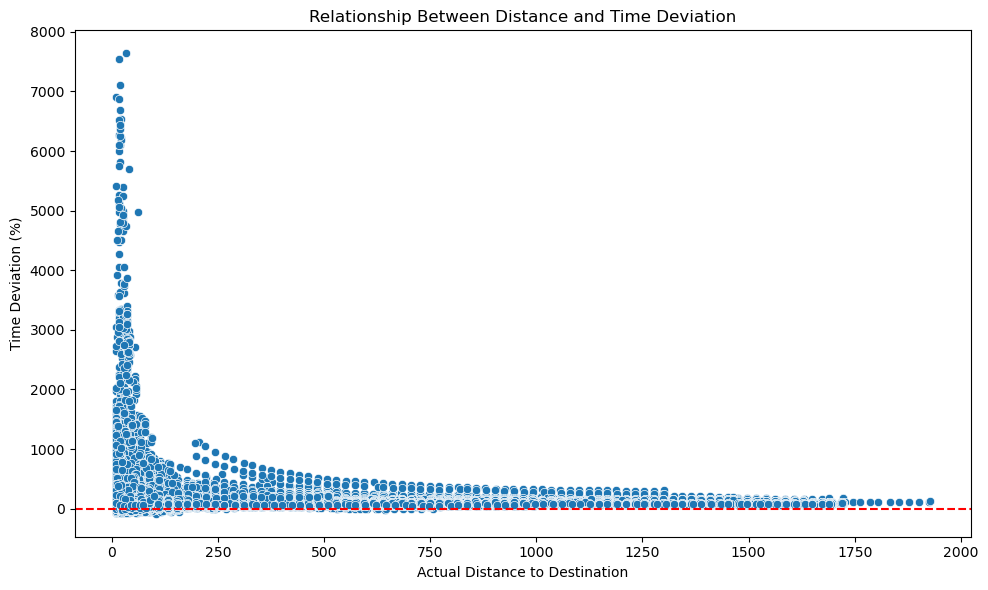


Correlation between distance and time deviation: -0.0647

Delivery Performance by Distance Range:
  distance_range  avg_deviation_pct  median_deviation_pct  trip_count  \
0           0-50         125.356909             82.758621       67374   
1         51-100         119.957785             90.384615       17860   
2        101-150         105.028412             87.272727        8544   
3        151-200          92.073869             82.242991        7751   
4        201-300          93.761232             84.313725        7973   
5        301-500          92.616976             84.789644       10615   
6       501-1000          92.340530             88.376754       16439   
7      1001-2000          93.696742             86.729452        8311   
8      2001-5000                NaN                   NaN           0   

   success_rate_pct  
0          4.215276  
1          1.047032  
2          0.819288  
3          0.064508  
4          0.062712  
5          0.000000  
6          0.091

C:\Users\milto\AppData\Local\Temp\ipykernel_12516\405266576.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  distance_performance = df.groupby('distance_range').agg({


In [22]:

plt.figure(figsize=(10, 6))
sns.scatterplot(x='actual_distance_to_destination', y='time_deviation_pct', data=df)
plt.title('Relationship Between Distance and Time Deviation')
plt.xlabel('Actual Distance to Destination')
plt.ylabel('Time Deviation (%)')
plt.axhline(y=0, color='red', linestyle='--')
plt.tight_layout()
plt.show()

# Calculate correlation coefficient
distance_time_corr = df['actual_distance_to_destination'].corr(df['time_deviation_pct'])
print(f"\nCorrelation between distance and time deviation: {distance_time_corr:.4f}")

# Analyze by distance ranges
distance_performance = df.groupby('distance_range').agg({
    'time_deviation_pct': ['mean', 'median', 'count'],
    'delivery_outcome': lambda x: (x == 'Early/On-Time').mean() * 100
}).reset_index()

distance_performance.columns = ['distance_range', 'avg_deviation_pct', 
                              'median_deviation_pct', 'trip_count', 'success_rate_pct']

print("\nDelivery Performance by Distance Range:")
print(distance_performance)

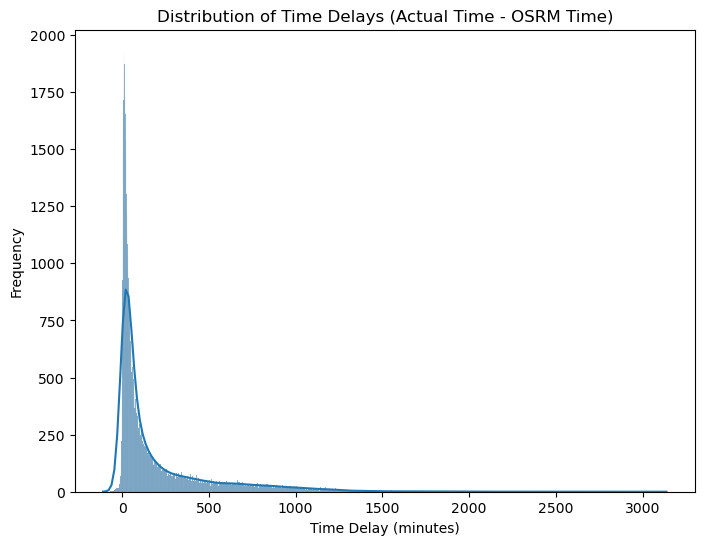

In [23]:
# Time Delay Analysis
df['time_delay'] = df['actual_time'] - df['osrm_time']
plt.figure(figsize=(8, 6))
sns.histplot(df['time_delay'], kde=True)
plt.title('Distribution of Time Delays (Actual Time - OSRM Time)')
plt.xlabel('Time Delay (minutes)')
plt.ylabel('Frequency')
plt.show()

### Key Observations:

1. **Shorter Trips (0-100 km)**:
- Have the highest time deviations and the lowest success rates.
- Possible reasons: Urban traffic, frequent stops, inefficient routing, or operational bottlenecks.

2. **Medium and Long-Distance Trips (101-2000 km)**:
- Time deviations are slightly lower than shorter trips, but success rates are still extremely low (close to 0%).
- Possible reasons: Longer travel times may compound delays, or there may be systemic issues affecting all trips regardless of distance.

3. **No Successful Trips in Some Ranges**:
- For trips over 300 km, the success rate is 0%, indicating that these trips are consistently delayed.
- This is a critical issue that needs further investigation.

4. **Distance is Not the Primary Driver of Delays**:
- The weak correlation between distance and time deviation (-0.0647) suggests that distance alone is not the main factor causing delays.
- Other factors (e.g., route type, time of day, operational inefficiencies) likely play a larger role.

## Conclusion

The high rate of significant delays, with **over 90%** of deliveries being delayed, signals critical inefficiencies in the logistics system that warrant immediate attention. The low percentage of on-time or early deliveries further highlights the need for more accurate time estimation and better route planning.

### Key Insights
    
1. FTL (Full Truck Load) route type exhibits worse performance compared to Carting, with higher delay rates and significant deviations between estimated and actual delivery times. This indicates systemic issues, possibly stemming from poor route optimization, traffic disruptions, or inaccurate delivery time predictions. Given that FTL accounts for a larger volume of trips, operational improvements should be prioritized in this area.
2. Route-specific issues were also highlighted, with the top 10 routes showing extreme delays, high variability in delivery times, and even a 100% delay rate on certain routes. The concentration of problematic routes in Uttar Pradesh and Maharashtra suggests regional operational challenges, which may require tailored interventions to address.
3. The analysis revealed that shorter trips, particularly those within urban areas, exhibit the highest time deviations and lowest success rates. These delays are likely caused by factors such as urban traffic, frequent stops, and operational bottlenecks. However, it is important to note that medium- and long-distance trips, despite having lower deviations, still suffer from extremely low success rates, pointing to systemic issues affecting deliveries across distances.
4. While distance was initially thought to be a major factor contributing to delays, the weak correlation between distance and time deviation suggests that other factors—such as route type, time of day, and operational inefficiencies—play a larger role in causing delays.